In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Lets download the airfoil data from UCI repository

In [15]:
import urllib.request

print('Downloading data')

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
urllib.request.urlretrieve(url, 'airfoil_self_noise.csv')

('airfoil_self_noise.csv', <http.client.HTTPMessage at 0x7f9218a60e20>)

## Read the data in numpy format (.npy)

In [16]:
col_names = ['Frequency','Angle of attack','Chord length','Velocity','Thickness','Sound pressure']

df = pd.read_csv('airfoil_self_noise.csv',delimiter='\t',names=col_names)
df.head()

Frequency  Angle of attack  Chord length  Velocity  Thickness  \
0        800              0.0        0.3048      71.3   0.002663   
1       1000              0.0        0.3048      71.3   0.002663   
2       1250              0.0        0.3048      71.3   0.002663   
3       1600              0.0        0.3048      71.3   0.002663   
4       2000              0.0        0.3048      71.3   0.002663   

   Sound pressure  
0         126.201  
1         125.201  
2         125.951  
3         127.591  
4         127.461

## Split the data to training and test

In [17]:
y = df["Sound pressure"].to_numpy()
X = df.drop("Sound pressure",axis = 1).to_numpy()
n = len(y)

I = np.random.permutation(n)
X = X[I]
y = y[I]

X = X/np.max(X,axis=0)
y = y/np.max(y)

X_train = X[0:np.int(4/5*n)]
y_train = y[0:np.int(4/5*n)]

X_test = X[np.int(4/5*n):]
y_test = y[np.int(4/5*n):]

Train loss =  0.1
Test loss =  0.1
R^2 = 0.48


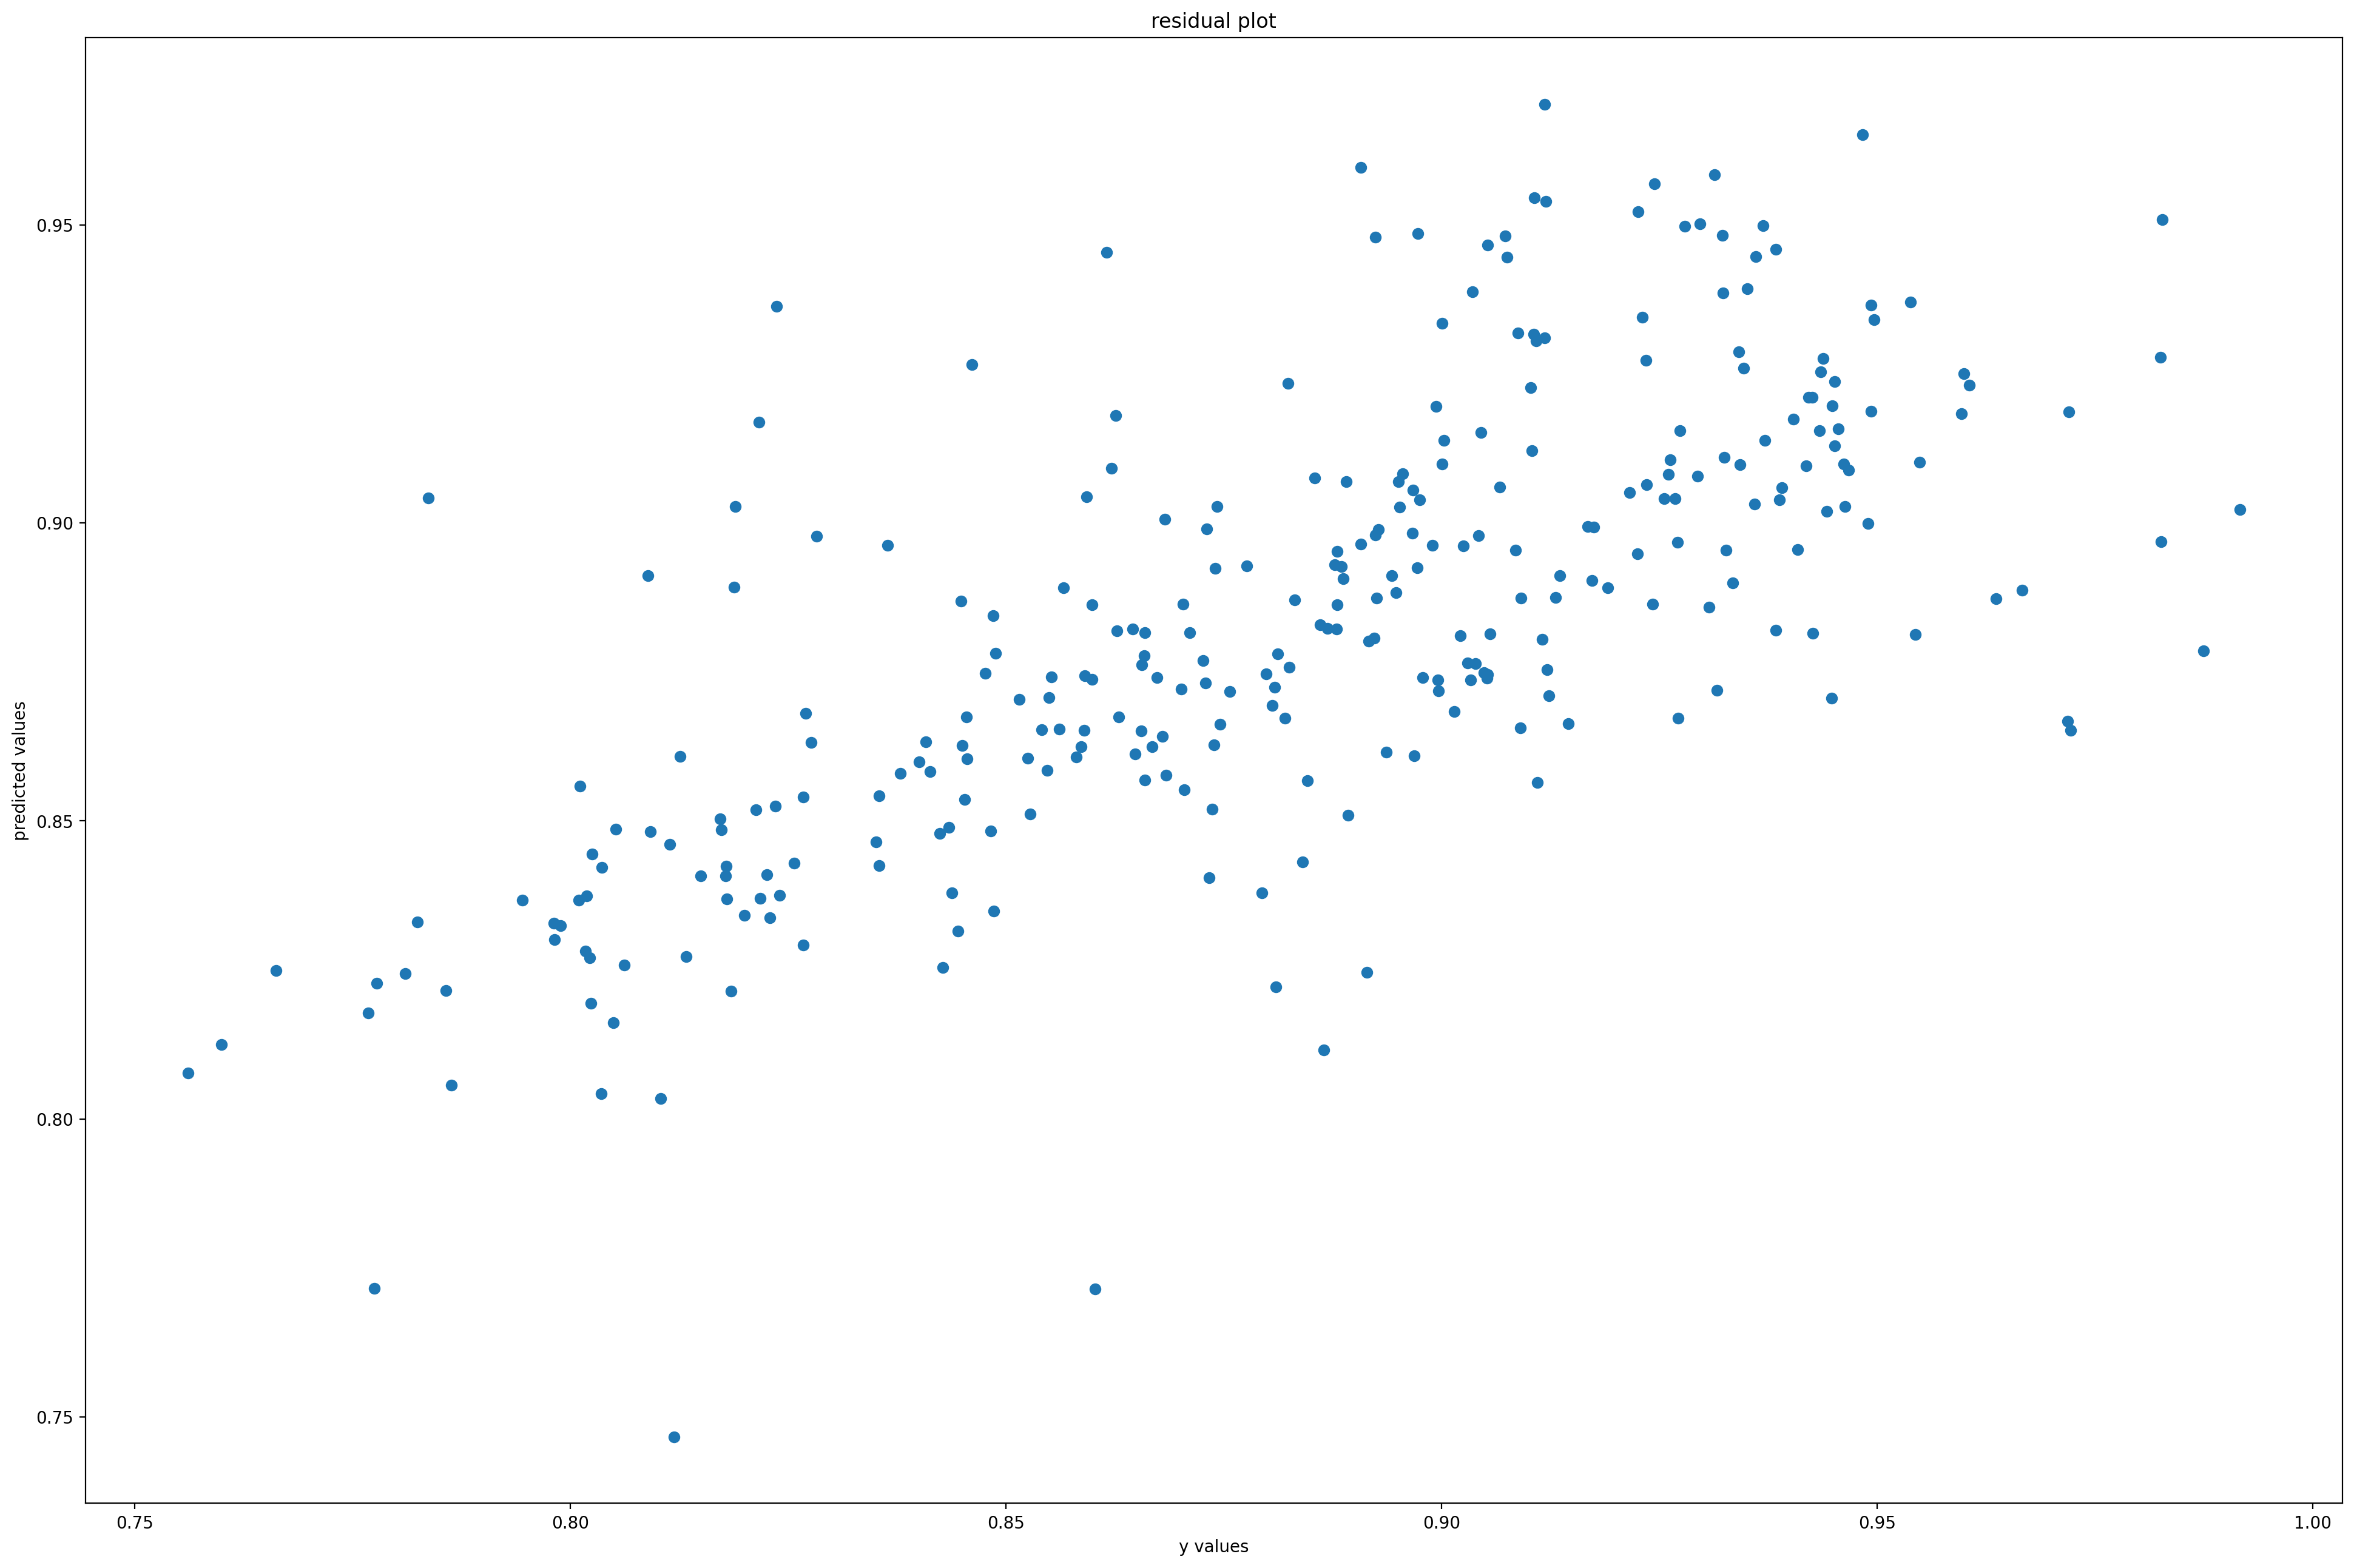

In [18]:
from sklearn.linear_model import LinearRegression

# Fitting
model = LinearRegression()
model.fit(X_train, y_train)

# Testting
train_loss = np.mean((model.predict(X_train) - y_train)**2)
test_loss = np.mean((model.predict(X_test) - y_test)**2)
print("Train loss = ", round(100*train_loss,1))
print("Test loss = ", round(100*test_loss,1))
R2 = 1 -  test_loss/np.var(y_test)
print("R^2 = " + str(np.round(R2,2)))

plt.scatter(y_test,model.predict(X_test))
plt.xlabel("y values")
plt.ylabel("predicted values")
plt.title("residual plot")
plt.show()


Train loss =  0.0
Test loss =  0.0
R^2 = 0.91


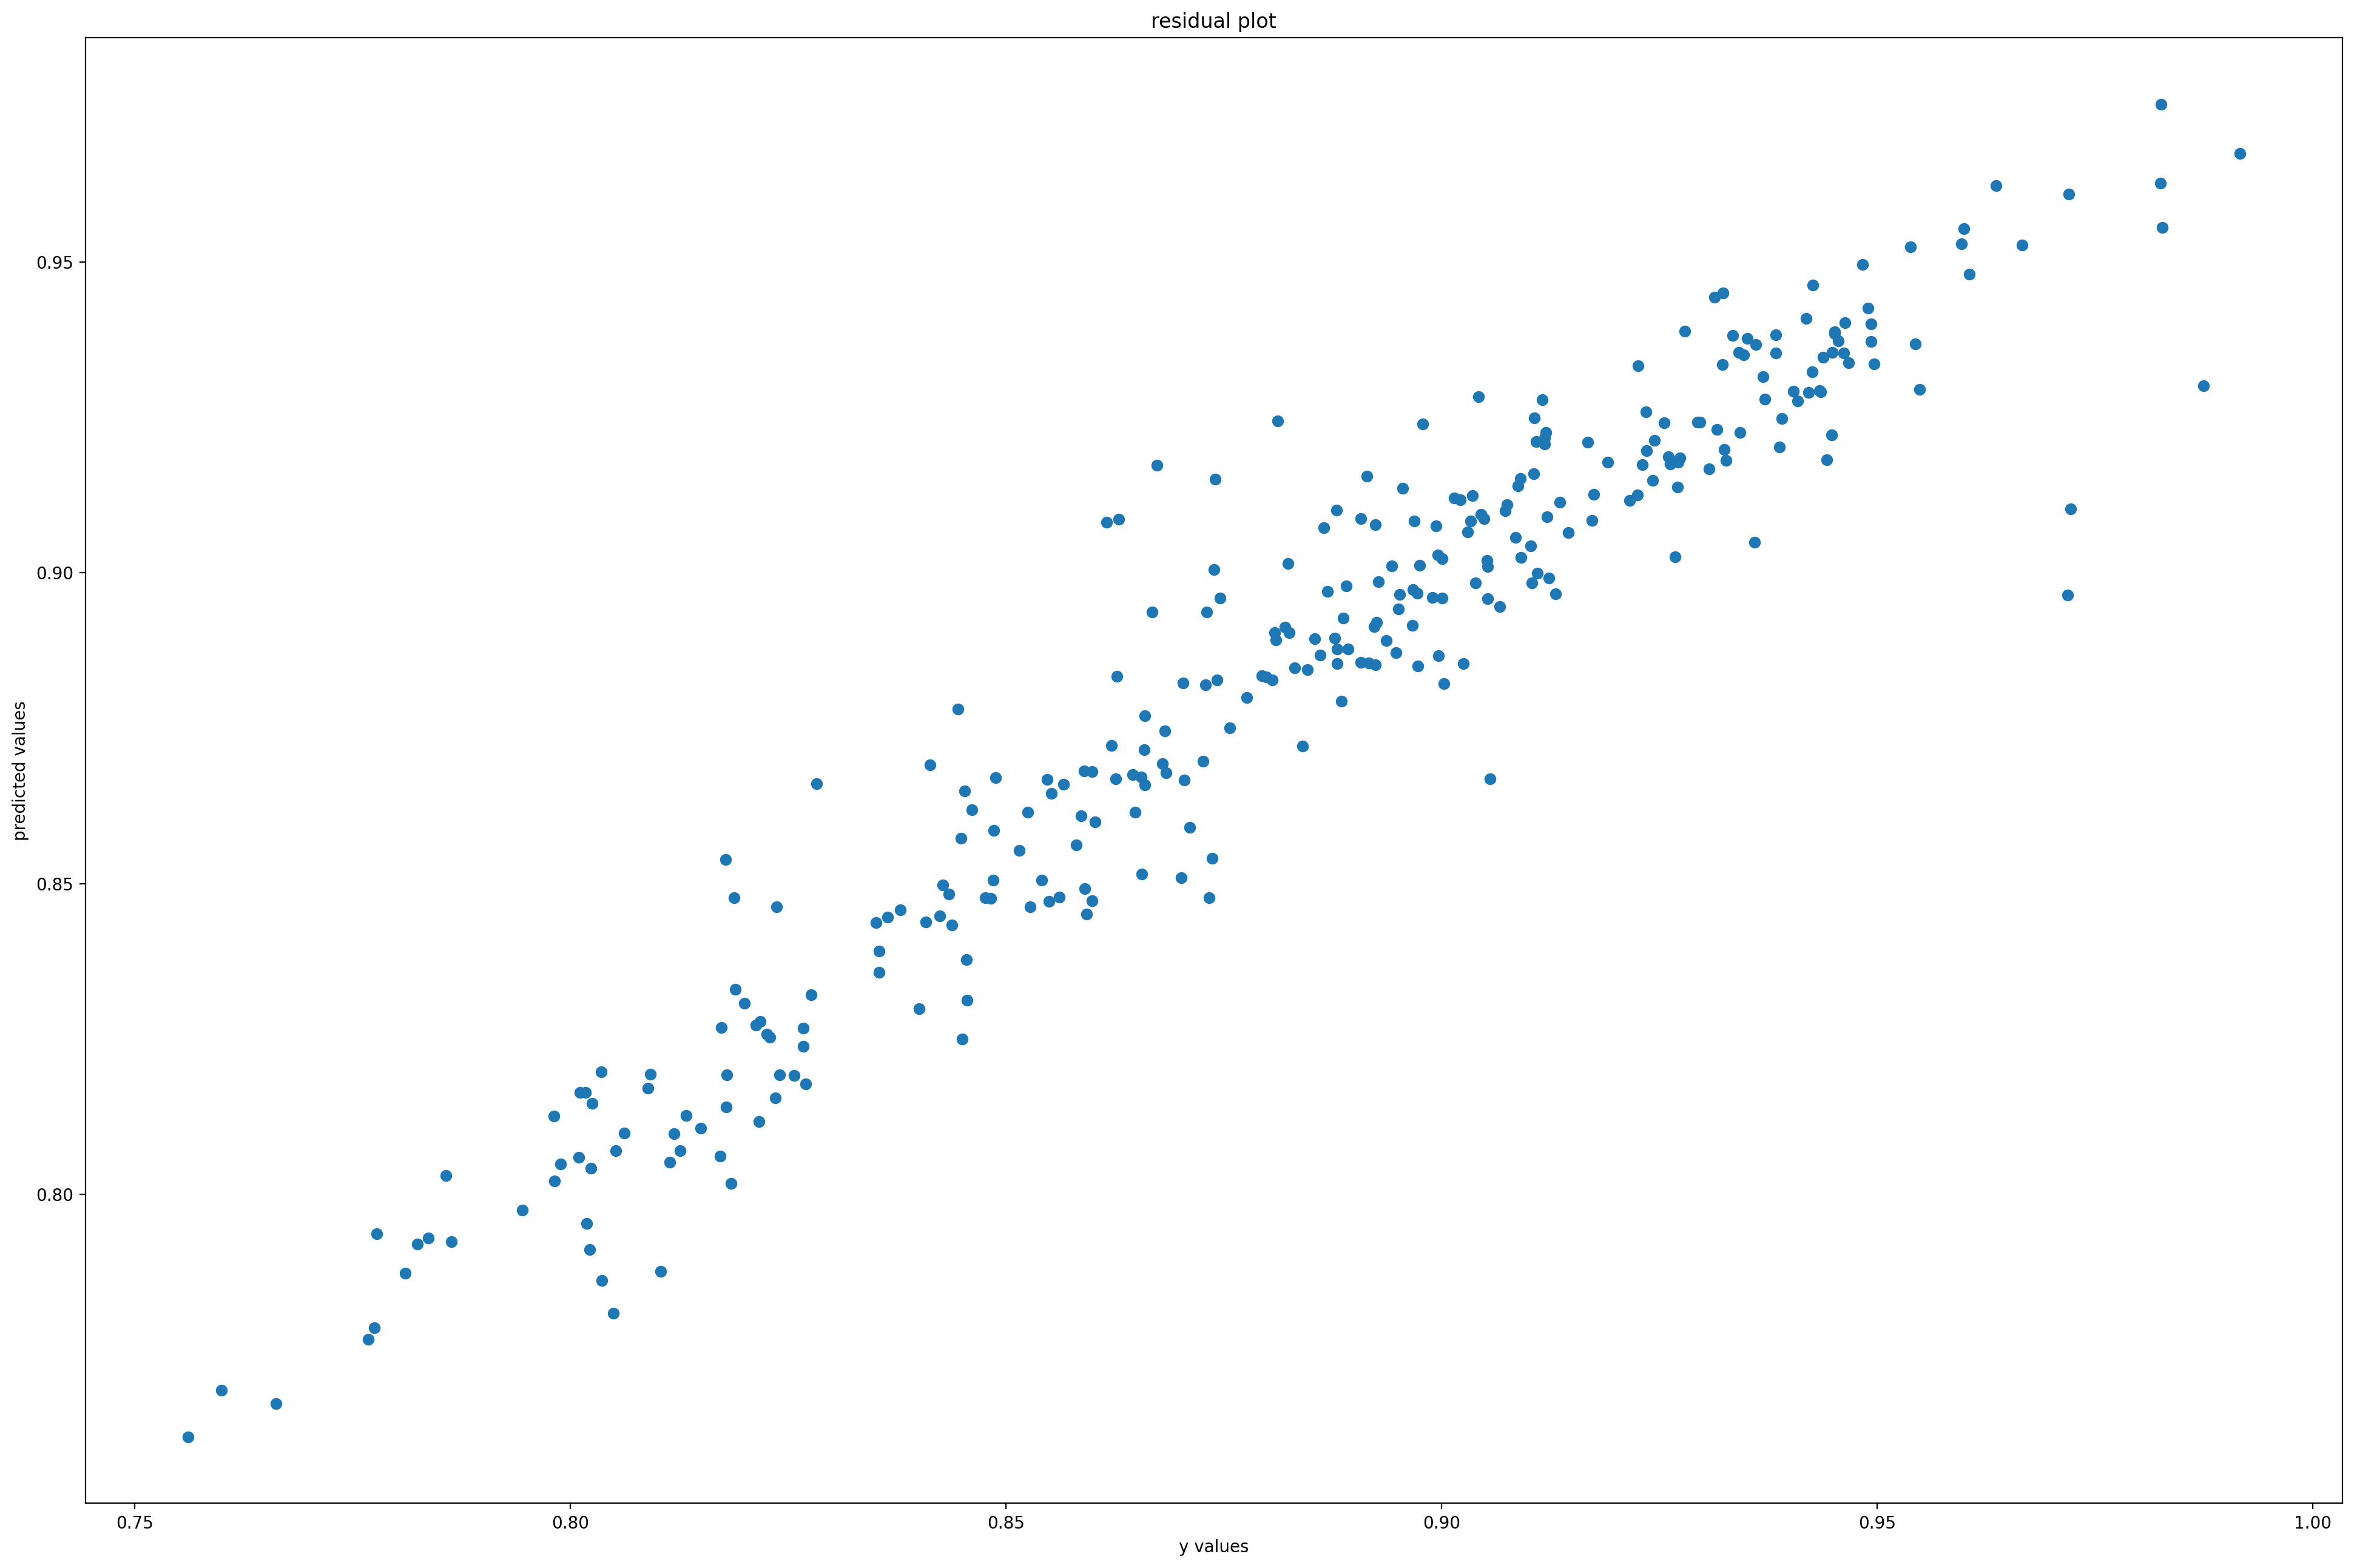

In [19]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=10, random_state=0).fit(X, y)

# Fitting
model.fit(X_train, y_train)

# Testting
train_loss = np.mean((model.predict(X_train) - y_train)**2)
test_loss = np.mean((model.predict(X_test) - y_test)**2)
print("Train loss = ", round(100*train_loss,1))
print("Test loss = ", round(100*test_loss,1))
R2 = 1 -  test_loss/np.var(y_test)
print("R^2 = " + str(np.round(R2,2)))


plt.scatter(y_test,model.predict(X_test))
plt.xlabel("y values")
plt.ylabel("predicted values")
plt.title("residual plot")
plt.show()

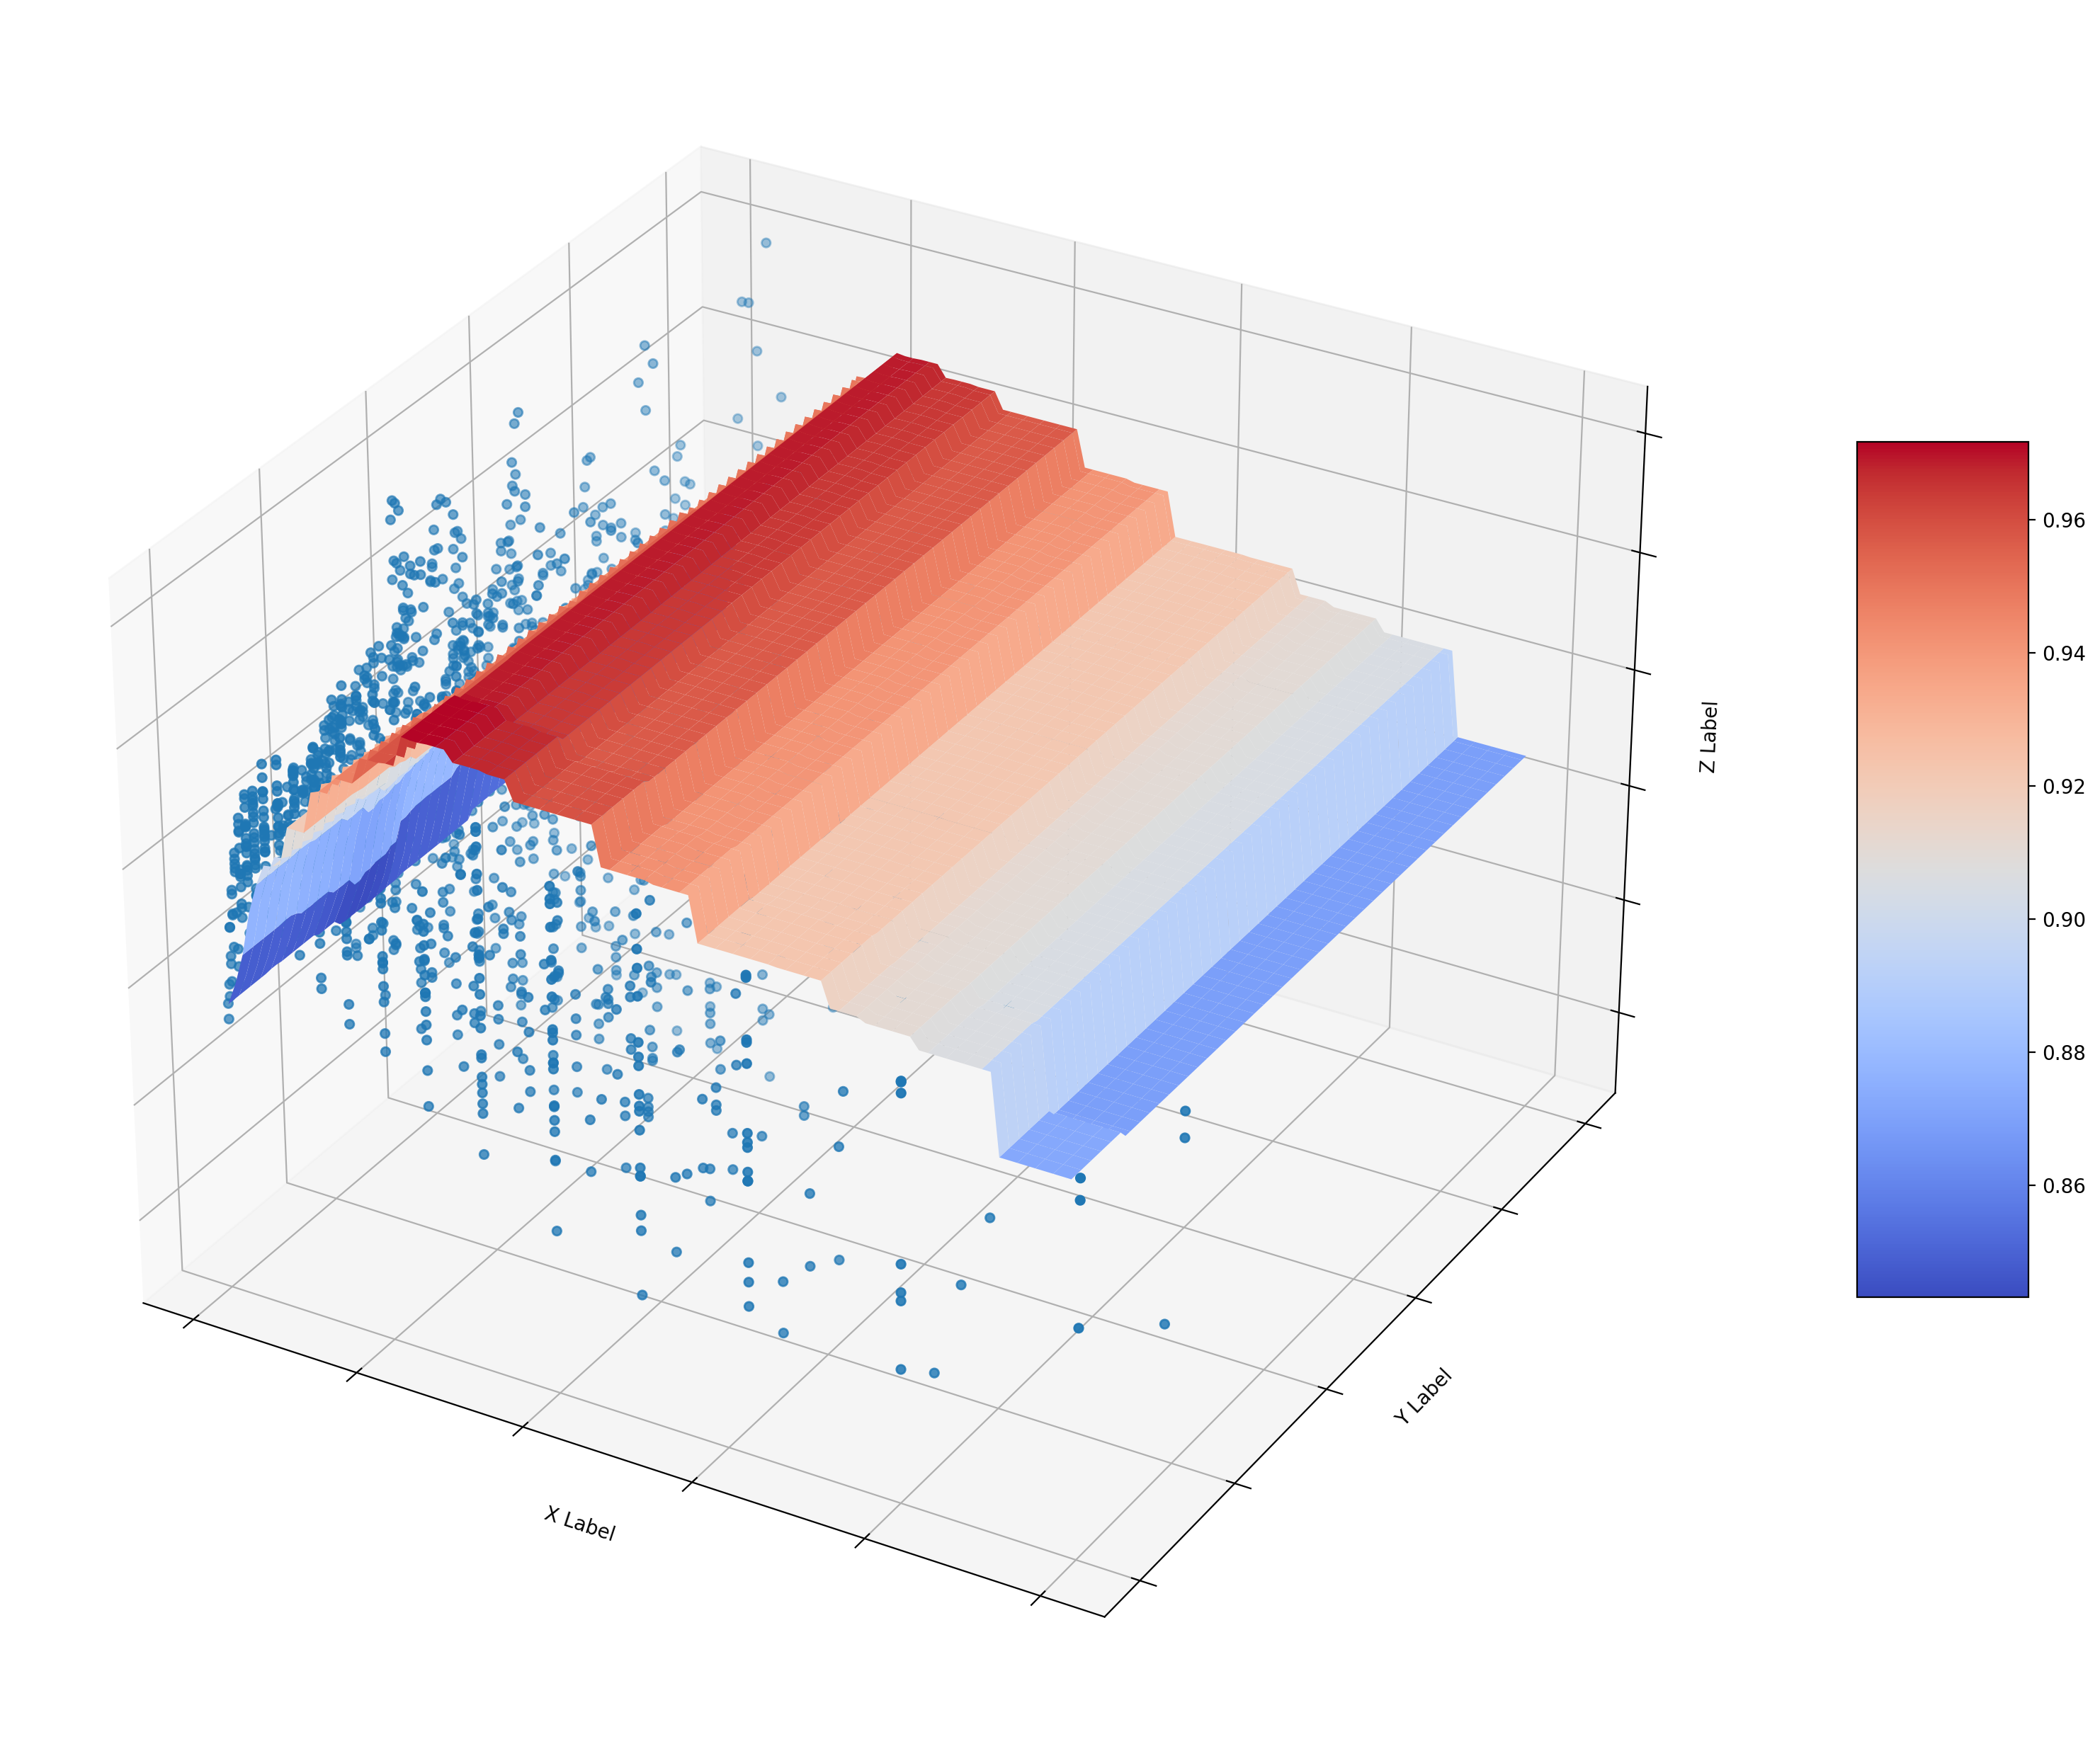

In [20]:
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

dim = X.shape[1]

plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

fig = plt.figure()
ax = fig.gca(projection='3d')

d_mesh = 0.01
X_mesh = np.arange(np.min(X[:,0]), np.max(X[:,0]), d_mesh)
Y_mesh = np.arange(np.min(X[:,1]), np.max(X[:,1]), d_mesh)
X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)

X_mesh_all = np.concatenate((X_mesh.reshape(-1,1),Y_mesh.reshape(-1,1)), axis=1)
if dim > 2:
    X_mesh_all = np.concatenate((X_mesh_all, np.zeros([X_mesh_all.shape[0], dim-2])), axis=1)

f_hat_mesh = model.predict(X_mesh_all).reshape(X_mesh.shape)

# Plot the surface.
surf = ax.plot_surface(X_mesh, Y_mesh, f_hat_mesh, cmap = cm.coolwarm)
ax.scatter(X[:,0],X[:,1],y)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])


plt.show()


Train loss =  tensor(0.)
Test loss =  tensor(0.)
R^2 = 0.9


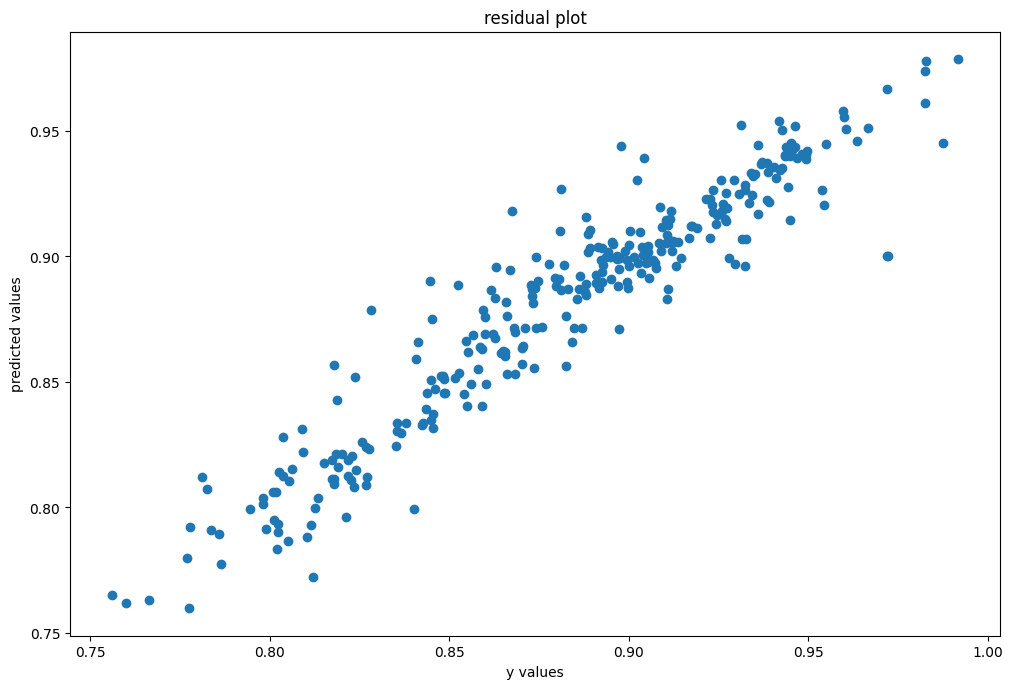

In [21]:
import torch as th
from dc_regression_gpu_inf import dc_regression

if th.cuda.is_available():
    device = th.device("cuda")          # a CUDA device object
else:
    device = th.device("cpu")

X_train_g = th.from_numpy(X_train.astype('float32')).to(device)
y_train_g = th.from_numpy(y_train.astype('float32')).to(device)  
X_test_g = th.from_numpy(X_test.astype('float32')).to(device)
y_test_g = th.from_numpy(y_test.astype('float32')).to(device)   

# Fitting
model = dc_regression()
th.cuda.empty_cache()  
model.fit(X_train_g,y_train_g, lanbda = 0.001, T=500*n)

# Testting
train_loss = th.mean((model.predict(X_train_g) - y_train_g)**2)
test_loss = th.mean((model.predict(X_test_g) - y_test_g)**2)
print("\nTrain loss = ", th.round(100*train_loss).cpu())
print("Test loss = ", th.round(100*test_loss).cpu())
R2 = 1 -  test_loss/th.var(y_test_g)
print("R^2 = " + str(th.round(100*R2).cpu().numpy()/100))

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.scatter(y_test_g.cpu().numpy(),model.predict(X_test_g).cpu().numpy())
plt.xlabel("y values")
plt.ylabel("predicted values")
plt.title("residual plot")
plt.show()

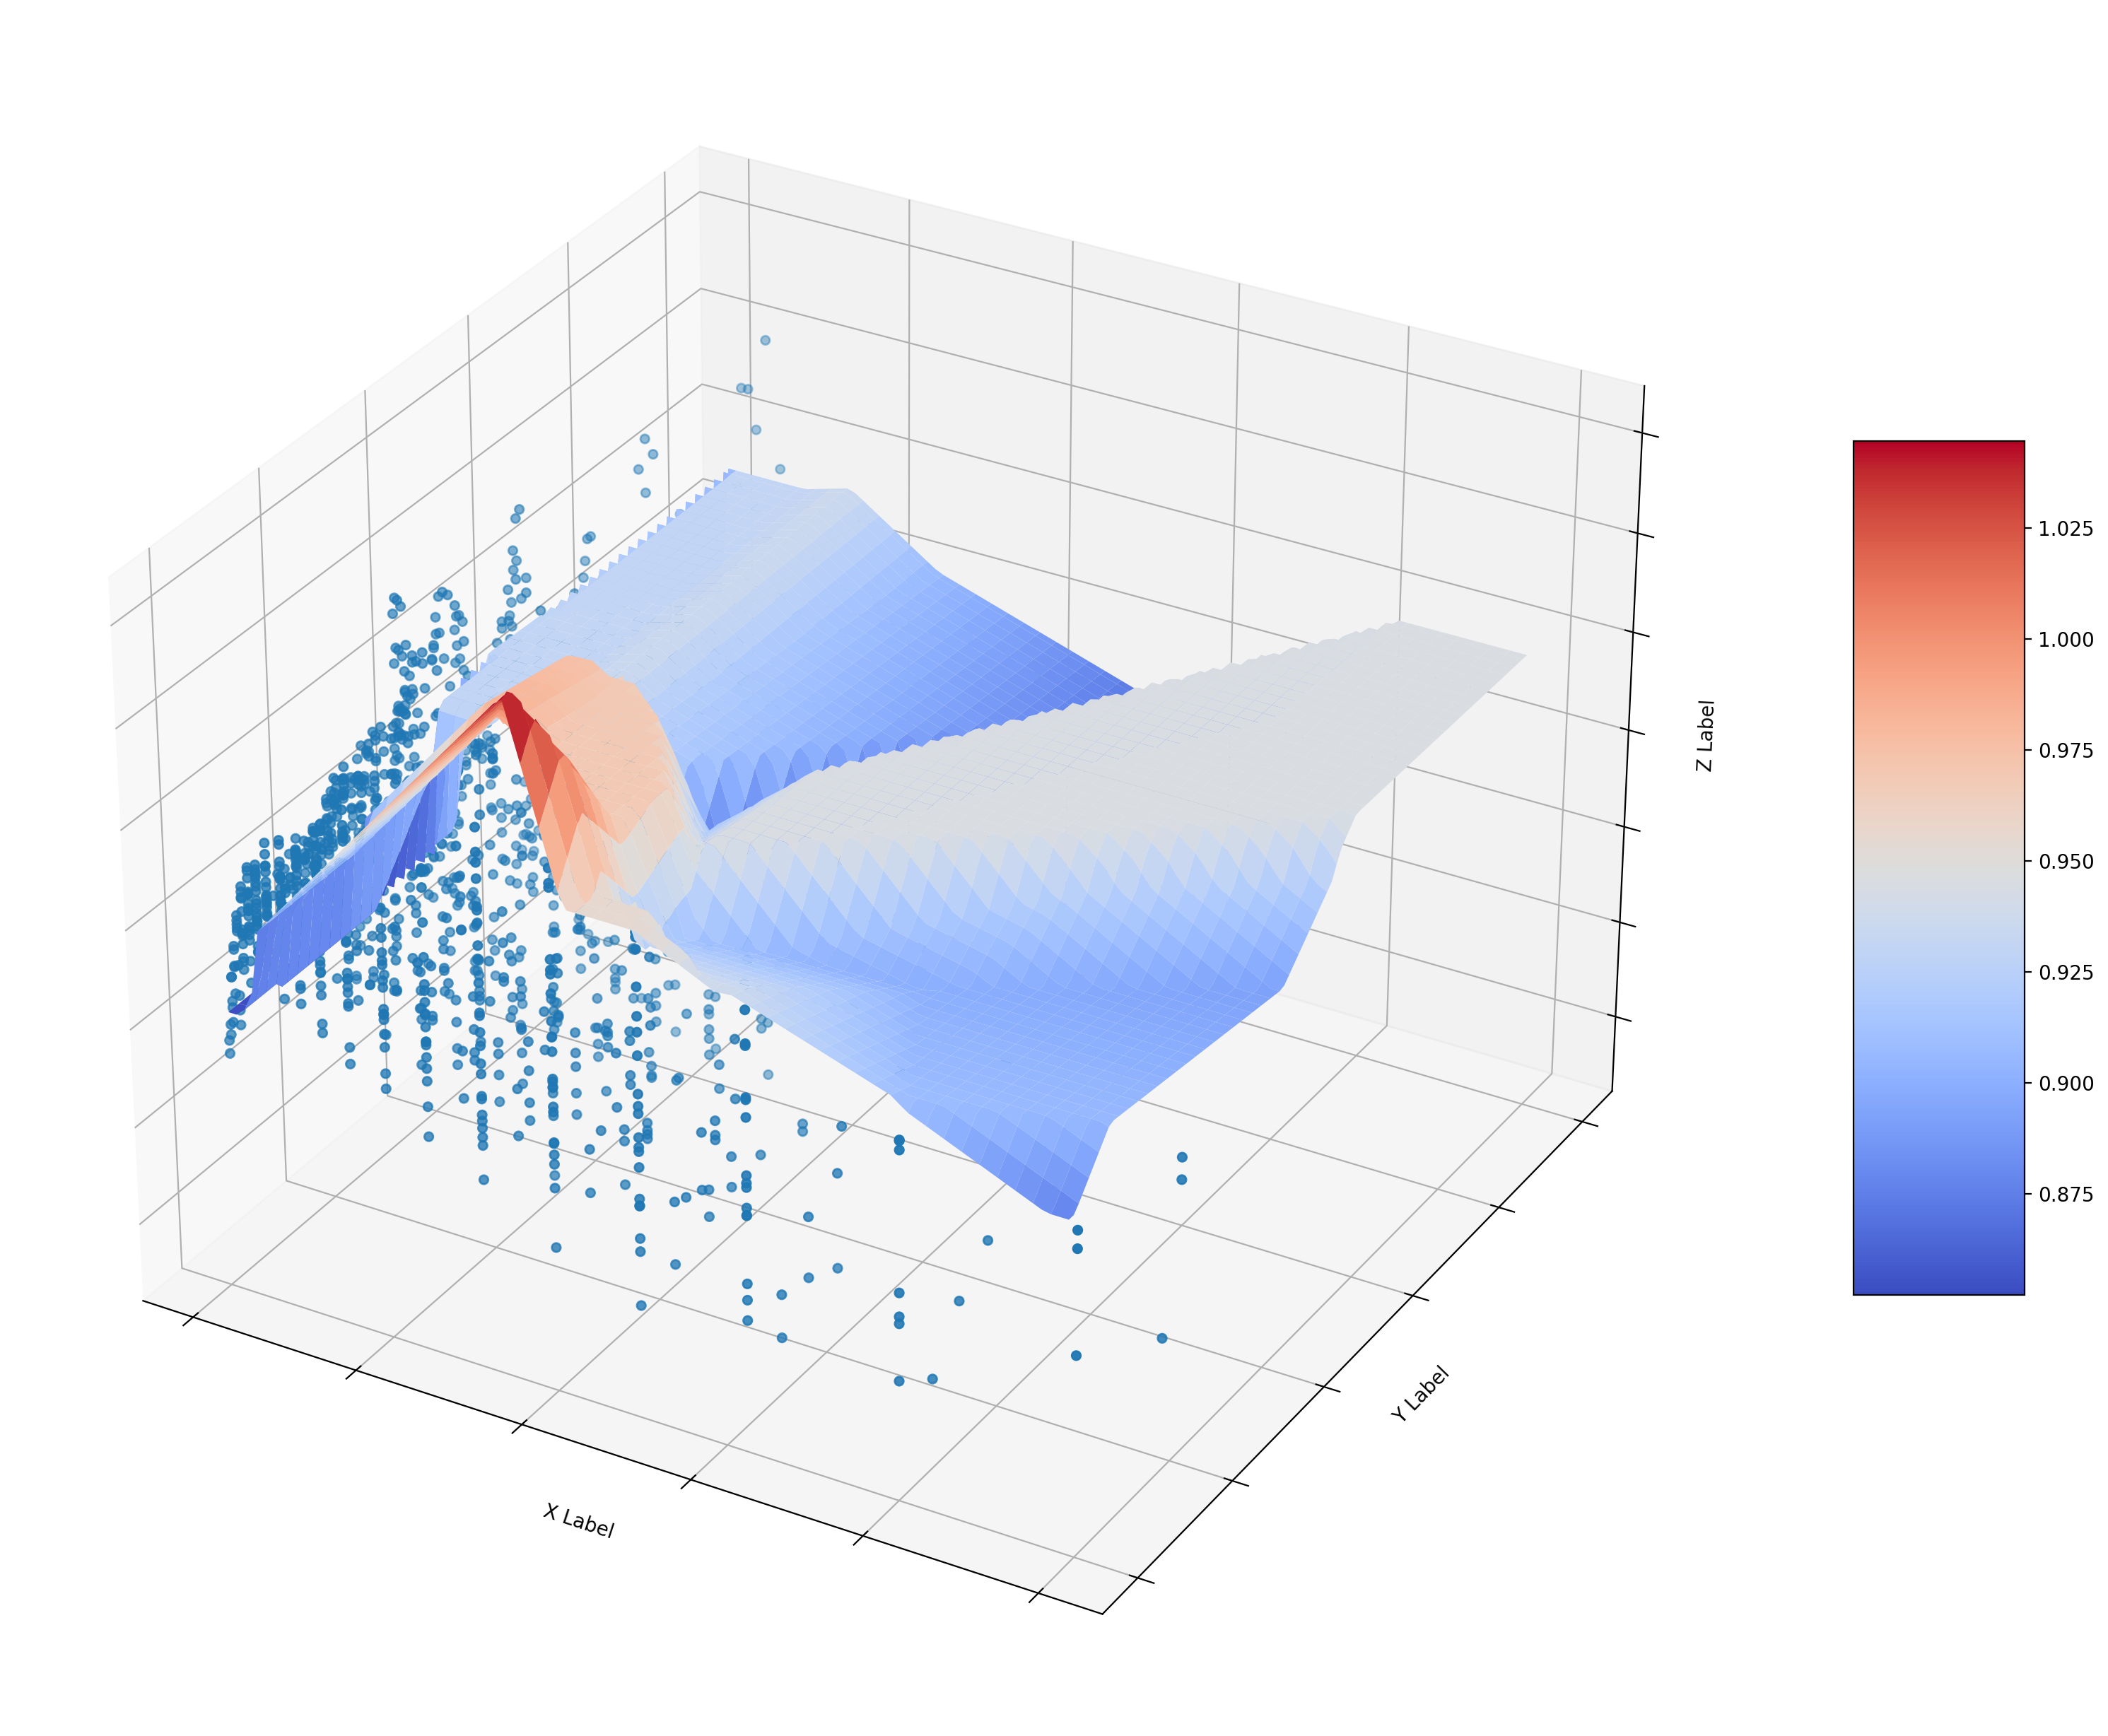

In [22]:
# Plotting
plt.rcParams['figure.figsize'] = [24, 16]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

fig = plt.figure()
ax = fig.gca(projection='3d')

d_mesh = 0.01
X_mesh = th.arange(th.min(th.tensor(X[:,0])), th.max(th.tensor(X[:,0])), d_mesh, device=device)
Y_mesh = th.arange(th.min(th.tensor(X[:,1])), th.max(th.tensor(X[:,1])), d_mesh, device=device)
X_mesh, Y_mesh = th.meshgrid(X_mesh, Y_mesh)

X_mesh_all = th.cat((X_mesh.reshape(-1,1), Y_mesh.reshape(-1,1)), dim=1)
if dim >2:
    X_mesh_all = th.cat((X_mesh_all,  th.zeros(X_mesh_all.shape[0],dim-2, device=device)), dim=1)

f_hat_mesh = model.predict(X_mesh_all).reshape(X_mesh.shape)


# Plot the surface.
surf = ax.plot_surface(X_mesh.cpu().numpy(), Y_mesh.cpu().numpy(), f_hat_mesh.cpu().numpy(), cmap = cm.coolwarm)
ax.scatter(X[:,0],X[:,1],y)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

plt.show()